# Практика 5, ч.1

1. "Хвосты" по вопросам: softmax, алгоритмы оптимизации - ч.1
2. Операция свертки (convolution). Необходимые слои НС, из арсенала pytorch: `nn.Conv2d, nn.BatchNorm2d, nn.Dropout` - ч.2
3. Современные архитектуры. Работа небольшой светрочной сети (на примере LeNet) - ч.2

## 1. Сигмоида и softmax

### Логистическая функция:
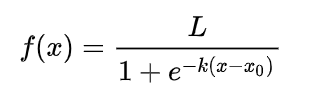

Параметры: **L** - верхний предел ("ёмкость среды"), **k** - коэффициент наклона лиенйного участка (крутизна), **х0** - срединная точка, разделитель двух классов. 

### Сигмоида
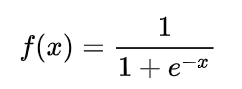

Частный случай логистической функции **(L = 1, k = 1, x0 = 0)**, ее также называют стандартной логистической функцией. Используется как функция активции последнего слоя НС в задачах бинароной классифиации.

### Softmax

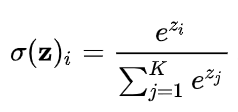

Многопеременная логистическая функция: преобразует вектор z размерности K в вектор σ той же размерности, где каждая координата 
σi полученного вектора представлена вещественным числом в интервале [0,1] и сумма координат равна 1 Это обобщение логистической функции на несколько измерений, используемое в полиномиальной логистической регрессии. Функция **softmax** часто используется как функция активации последнего слоя нейронной сети для нормализации данных и распределения вероятностей по предсказанным выходным классам в **многоклассовых задачах**.

In [5]:
import numpy as np
def softmax(x):
    x_sum = np.sum(np.exp(x))
    
    return np.exp(x) / x_sum

In [6]:
x = np.array([2, 1, 7, 4, 1, 3, 5])
x_softed = softmax(x)
x_softed

array([0.00554503, 0.0020399 , 0.82295488, 0.04097251, 0.0020399 ,
       0.01507294, 0.11137483])

In [7]:
x_softed.sum()

1.0

In [4]:
import torch
import torch.nn.functional as F

x_tensor = torch.tensor(x, dtype=torch.float32)
x_tensor 
torch_softed = F.softmax(x_tensor, dim=0)
torch_softed

tensor([0.0055, 0.0020, 0.8230, 0.0410, 0.0020, 0.0151, 0.1114])

## 2. Алгоритмы оптимизации

**1. Задача оптимицазии:** поиск экстремума функции. Машинное обучение: поиск глобального минимума (точки где функция принимает минимальное значение). Оптимизируется обычно многомерная функция (д.б. дифференцируемой и выпуклой или псевдовыпуклой). **LR (темп обучения - learning rate)** - ключевой гиперпараметр, первое что можно и нужно подбирать. Аналогия: шарик стримится на дно чаши (минимум потенциальной Е) - "есстественная оптимизация" силой тяжести.
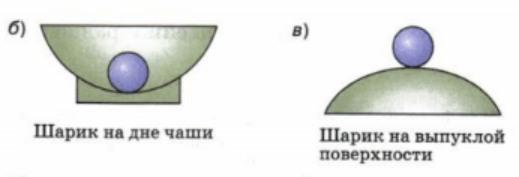


**Пример: вместо чаши пэт-пакет и что-то мелкое и легкое (мелкий шарик, крупинка):**
1. Кладем на край и постоянно сильно трясем (большой LR - никогда точно не будет в минимуме - будет постоянно проскакивать).
2. Кладем на край, аккуратно спихиваем и слабо потряхиваем (сильно нельзя!) - скорее всего, застрянет в складке (малый LR - может не хватить шага для выхода из локального минимума).

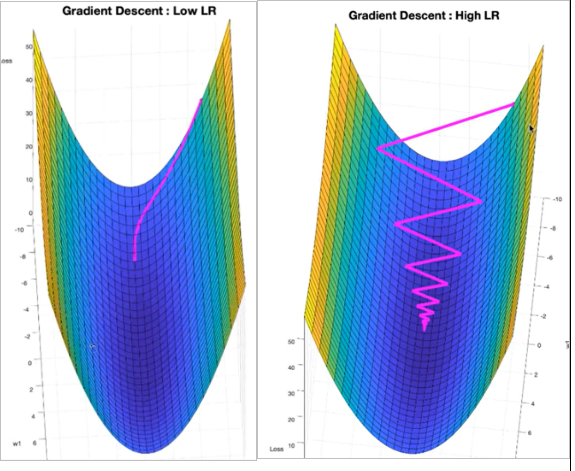

**Как решить проблему размера шагов на пути к минимуму, т.е. подобрать оптимальное значение LR?** Пока запомним эту проблему, переключимся на другую: бывает так что одно гениальное решение приходит при рассмотрении сразу нескольких проблем.

**2. Проблема оптимизации больших выборок:** вычислительная сложность. Особенно для современных больших датасетов (ImageNet - 14 млн изоражений) и данных высокого разрешения.
- **Решение-1:** приближаем градиент всей выборки градиентом одного случайного элемента
- **Решение-2 (лучше):** приближаем градиент всей выборки градиентом по небольшой случайной подвыборке элементов == batch (minibatch). Преимущества векторизации и параллельных расчетов, гораздо точнее чем по одному элементу.

Эта идея - в основе SGD (Stochastic Gradient Descent - случайный градиентный спуск), базового алгоритма оптимизации при обучении современных НС. В "классическом" варианте SGD размер шагов на пути к минимуму фиксирован. Если функция дифференцируемая и выпуклая - SGD при опеределенном значении LR сойдется к глобальному минимуму (или к локальному - если функция не выпуклая).

Вспоминаем о проблеме оптимального размера шага оптимизации, но теперь процесс сам по себе пошаговый (данные берутя батчами; каждый батч разный; обработка одного батча == один шаг). **А давайте сделаем шаги в процедуре оптимизации тоже разными. т.е. переменными по размеру?** Например будем сперва делать их большими (преодаление всех локальных минимумов функции: грубо, но быстро) а потом снижать (приход к самому дну глобального минимума: медленно, но предсказуемо и точно).

Эта идея - в основе алгоритмов с т.н. **momentum** ("импульсом", т.е. "памятью" результатов предыдущего шага для расчета размера следующего). Моментум - небольшая вычислительная добавка к алгоритму оптимизации, это и есть то, что дает переменный размер шага. Конкретные вычислительные реализации моментума м.б. разные, но суть одна: переменный шаг оптимизации, как правило сперва шаги большие и постепенно уменьшаются. При этом значения стабильны и близки к гиперповерхности многомерной функции, котору мы оптимизируем.

### 2.1 SGD with momentum
В формулу обновления градиента добавляется расчет т.н. скользящего среднего (MA - moving average) по последним двум точкам. Стандартное обновление весов (*α* = LR):

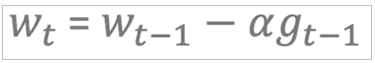

Обновление весов с МА:

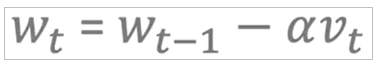

Где *v<sub>t</sub>* рассчитвается по формуле:

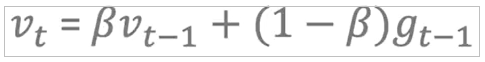

Здесь *v<sub>t</sub>* и представляет расчет скользящего среднего, учитывает еще и предыдущее значение градиента: в него входят *v<sub>t</sub>* предыдущего шага, а также *g<sub>t</sub>* (градиент предыдущего шага).  *β* - собственно, коэффициент моментума, (вклада предыдущих шагов) и тоже является гиперпараметром (хорошо работает значение 0.9)


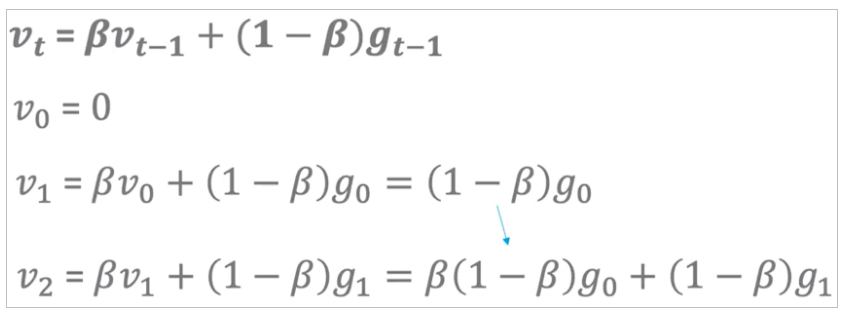

Таким образром, по ходу вычислений с каждым батчем *v<sub>t</sub>* постепенно накапливает историю (моментум) прошлых шагов, влияющую на текущий шаг расчета градиента.

Эффект SGD c momentum: большой и малый LR:

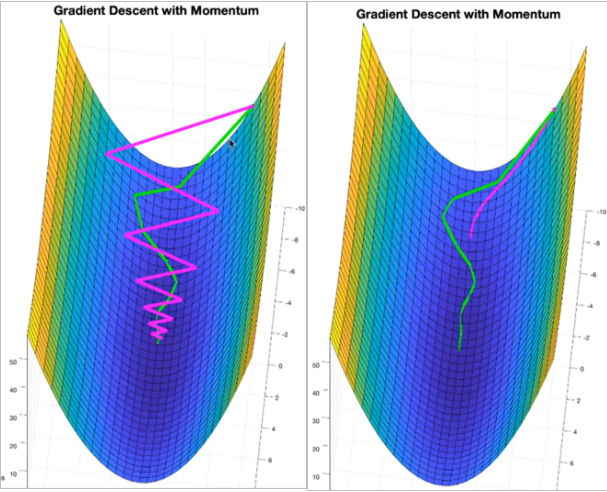

### 2.2 RMSProp (Root Mean Square Prop)

А что если в формуле обновления весов SGD сделать размер шага обратнопропорциональным к величине градиента? Тогда на малых градиентах ("плато") будут большие шаги, а на резких перепадах "рельефа" - малые. Для этого надо взять такую же скользящую среднюю, но по квадратам значений градиента:

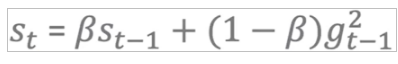

Формула обновления весов для RMSProp будет следующая (*ε* - обычно малое значение, 10<sup>-8</sup> степени по умолчанию - чтобы исключить ваозможность деоения на 0):

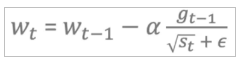

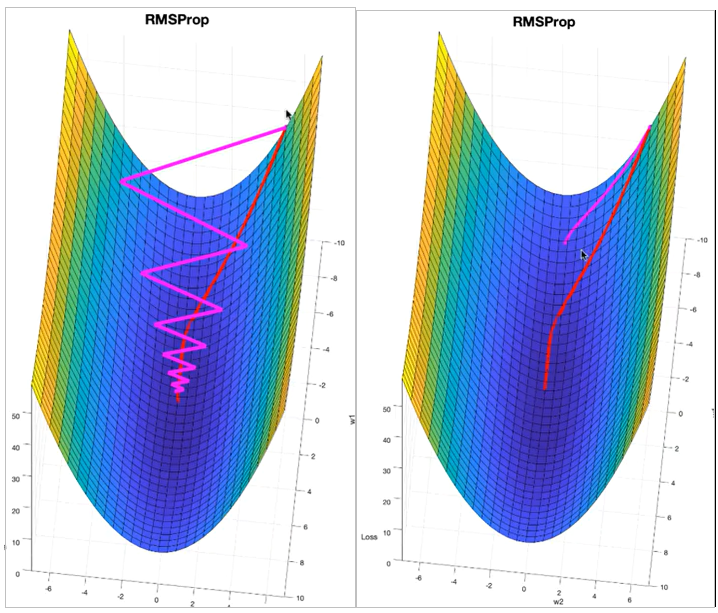

### 2.3 Adam (Adaptive Momentum Estimation)

Adam это комбинация свойств SGD c momentum и RMSProp: расчет обновления весов включает историю значений градиента, так и квадратов значений градиента, с добавлением выражения для корректировки в знаменатель *1 - β<sub>2</sub><sup>t</sup>* (bias correction term):

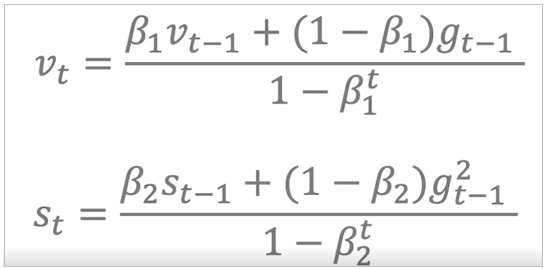

Поправка нужна, т.к. при начальных условиях хорошо работающие в дальнейшем значения *β<sub>1</sub>* = 0.9 и *β<sub>2</sub>* = 0.999 делают вклад градиента малым, что ведет к замедлению обучения:

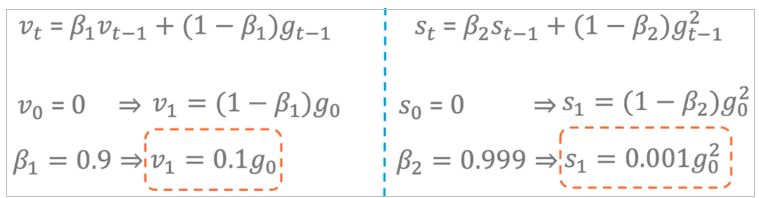

Первый проход с поправкой (*v<sub>t</sub>*, *s<sub>t</sub>* = 0): вклад только градиета, потенциально больший шаг (что и нужно):

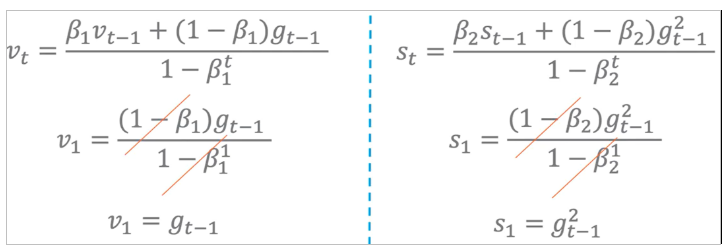

Далее c каждой следующей итерацией *β<sub>2</sub><sup>t</sup>* довольно быстро --> 0 и все выражение --> к числителю.

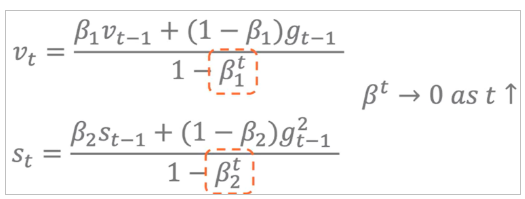

Формула для обновления весов в Adam будет содержать два параметра - *v<sub>t</sub>* и *s<sub>t</sub>*:

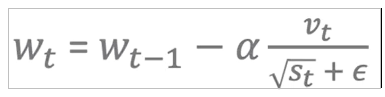

Формально *β<sub>1</sub>*, *β<sub>2</sub>* и *ε* - гиперпараметры. Но указанные значения хорошо работают. Реальный гиперпараметр - темп обучения (*α*).

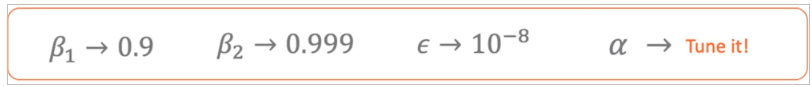

#### SGD-momentum (green) VS RMSProp (red) VS Adam (black)

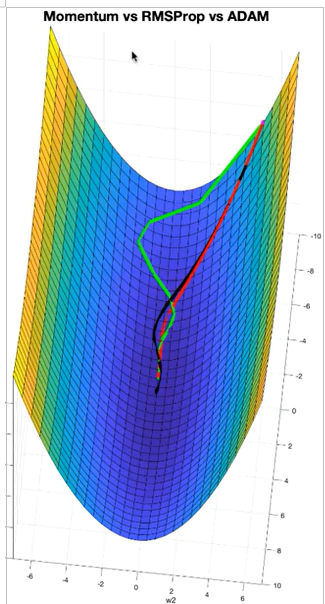

### Ссылки:
- Популярно про ландшафты функций потерь и <a href='https://habr.com/ru/companies/skillfactory/articles/552394/' a> и сложности оптимизации
- Анимированные примеры и толковая статья <a href='https://habr.com/ru/articles/318970/' a>по алгоритмам оптимизации
- Алгоритмы оптимизации: <a href='https://habr.com/ru/articles/272679/разборэ' a> разбор и реализация на python